# Score de risque de récidive

### Importation des librairies

In [1]:
#Importation des librairies

import numpy as np
import pandas as pd

import datetime
import scipy
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime

import os
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.datasets import make_hastie_10_2
from sklearn.metrics import RocCurveDisplay

from sklearn.utils import resample
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import f1_score, roc_auc_score

from IPython.display import display
pd.options.display.max_columns = None

import missingno as msno


from pycaret.classification import *

import shap
import xgboost
import xgboost as xgb

### Importation des données

In [2]:
# import pandas as pd
compas_scores_raw = pd.read_csv("./archive/compas-scores-raw.csv")

### Exploration des données 

In [3]:
# visualisation des premières lignes  
compas_scores_raw.head()

,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,ScaleSet_ID,ScaleSet,AssessmentReason,Language,LegalStatus,CustodyStatus,MaritalStatus,Screening_Date,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
0,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,7,Risk of Violence,-2.08,4,Low,New,1,0
1,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,8,Risk of Recidivism,-1.06,2,Low,New,1,0
2,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,18,Risk of Failure to Appear,15.00,1,Low,New,1,0
3,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Married,1/1/13 0:00,1,Low,7,Risk of Violence,-2.84,2,Low,New,1,0
4,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Married,1/1/13 0:00,1,Low,8,Risk of Recidivism,-1.50,1,Low,New,1,0


In [4]:
# Dimension de la dataset
compas_scores_raw.shape

(60843, 28)

In [5]:
# liste des colonnes 
compas_scores_raw.columns

Index(['Person_ID', 'AssessmentID', 'Case_ID', 'Agency_Text', 'LastName',
       'FirstName', 'MiddleName', 'Sex_Code_Text', 'Ethnic_Code_Text',
       'DateOfBirth', 'ScaleSet_ID', 'ScaleSet', 'AssessmentReason',
       'Language', 'LegalStatus', 'CustodyStatus', 'MaritalStatus',
       'Screening_Date', 'RecSupervisionLevel', 'RecSupervisionLevelText',
       'Scale_ID', 'DisplayText', 'RawScore', 'DecileScore', 'ScoreText',
       'AssessmentType', 'IsCompleted', 'IsDeleted'],
      dtype='object')

In [6]:
# Types des variables 
compas_scores_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60843 entries, 0 to 60842
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person_ID                60843 non-null  int64  
 1   AssessmentID             60843 non-null  int64  
 2   Case_ID                  60843 non-null  int64  
 3   Agency_Text              60843 non-null  object 
 4   LastName                 60843 non-null  object 
 5   FirstName                60843 non-null  object 
 6   MiddleName               15648 non-null  object 
 7   Sex_Code_Text            60843 non-null  object 
 8   Ethnic_Code_Text         60843 non-null  object 
 9   DateOfBirth              60843 non-null  object 
 10  ScaleSet_ID              60843 non-null  int64  
 11  ScaleSet                 60843 non-null  object 
 12  AssessmentReason         60843 non-null  object 
 13  Language                 60843 non-null  object 
 14  LegalStatus           

<Axes: >

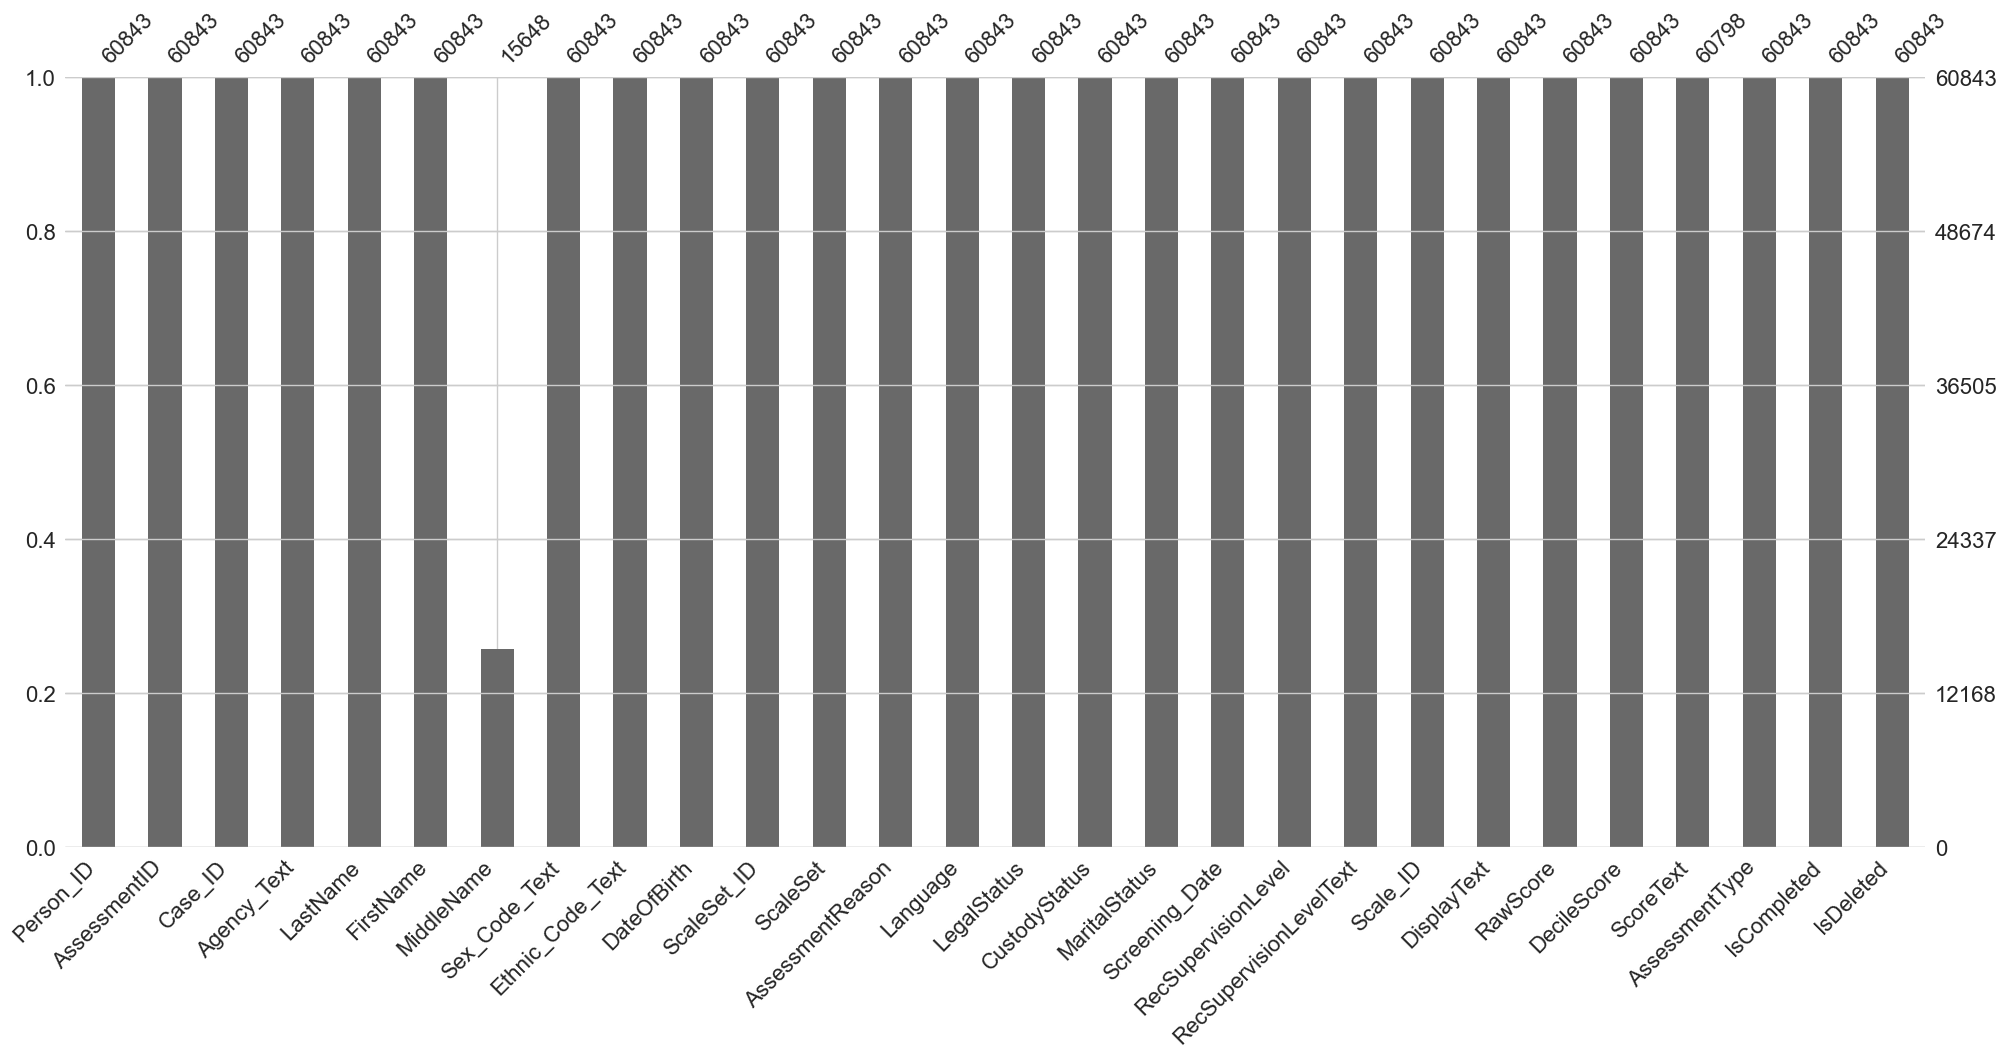

In [7]:
# Analyse des valeurs manquantes 
msno.bar(compas_scores_raw)

on a presque pas de 

### Feature Engineering (Traitement des données)

#### Calcule de l'âge lors de l'arrestation 

In [8]:
# Définition de la fonction qui calcule l'âge en années
def dateOfBirthTransform(P,G):
    
    formatting = "%m/%d/%Y"
    x = P.split("/")
    if x[-2] == "0":
        x[-1] = "20" + x[-1][-2:]
    else:
        x[-1] = "19" + x[-1][-2:] # remplace les deux derniers caractères par "19" + les deux derniers caractères
    date_string = "/".join(x)
#     print(x)
    date2 = datetime.strptime(G, '%m/%d/%y %H:%M')
    date_object = datetime.strptime(date_string, formatting)

    
    age = (date2 - date_object).days // 365
#     print("Age:", age)
    return int(age)
# Application de la fonction à chaque ligne du dataframe
#compas_scores_raw["Age"] = compas_scores_raw.apply(dateOfBirthTransform, axis=1)
compas_scores_raw['years']=compas_scores_raw.apply(lambda row: dateOfBirthTransform(row["DateOfBirth"], row["Screening_Date"]), axis=1)

In [9]:
#Liste des variables
compas_scores_raw.columns

Index(['Person_ID', 'AssessmentID', 'Case_ID', 'Agency_Text', 'LastName',
       'FirstName', 'MiddleName', 'Sex_Code_Text', 'Ethnic_Code_Text',
       'DateOfBirth', 'ScaleSet_ID', 'ScaleSet', 'AssessmentReason',
       'Language', 'LegalStatus', 'CustodyStatus', 'MaritalStatus',
       'Screening_Date', 'RecSupervisionLevel', 'RecSupervisionLevelText',
       'Scale_ID', 'DisplayText', 'RawScore', 'DecileScore', 'ScoreText',
       'AssessmentType', 'IsCompleted', 'IsDeleted', 'years'],
      dtype='object')

#### Jointure des modalités 'African-Am' et 'African-American' de la variable Ethnic_Code_Text.

In [10]:
#unir African-American anetd African-Am sur le même groupe ethinique 
compas_scores_raw["Ethnic_Code_Text"] = compas_scores_raw["Ethnic_Code_Text"].replace({"African-Am": "African-American"})

#### Suppression des colonnes moins pertinentes pour notre analyse. 

In [11]:
#Suppression de certainnes colonnes 
compas_scores_raw = compas_scores_raw.drop(['AssessmentID', 'Case_ID',  'LastName',
       'FirstName', 'MiddleName', 'DateOfBirth', 'ScaleSet_ID', 'ScaleSet', 'AssessmentReason',
       'Screening_Date', 'Scale_ID',  'AssessmentType', 'IsCompleted', 'IsDeleted', ], axis=1)

In [12]:
# compas_scores_raw[['AssessmentID', 'Case_ID', 'LastName',
#        'FirstName', 'MiddleName', 'DateOfBirth', 'ScaleSet_ID',  'AssessmentReason',
#        'Screening_Date', 'Scale_ID','AssessmentType', 'IsCompleted', 'IsDeleted' ]]

In [13]:

# # Compter le nombre de modalités distinctes
# nb_modalites = len(compas_scores_raw["Ethnic_Code_Text"].unique())

# # Afficher le nombre de modalités
# print("Le nombre de modalités dans la variable", "AssessmentReason" , "est de", nb_modalites)


In [14]:
# # Compter le nombre de fois que chaque modalité est représentée
# counts = compas_scores_raw["Ethnic_Code_Text"].value_counts()

# # Afficher le nombre de fois que chaque modalité est représentée
# print(counts)


In [15]:
# Dismention de la nouvelle dataset
compas_scores_raw.shape

(60843, 15)

In [16]:
# dataSet
compas_scores_raw.head()

,Person_ID,Agency_Text,Sex_Code_Text,Ethnic_Code_Text,Language,LegalStatus,CustodyStatus,MaritalStatus,RecSupervisionLevel,RecSupervisionLevelText,DisplayText,RawScore,DecileScore,ScoreText,years
0,50844,PRETRIAL,Male,Caucasian,English,Pretrial,Jail Inmate,Single,1,Low,Risk of Violence,-2.08,4,Low,20
1,50844,PRETRIAL,Male,Caucasian,English,Pretrial,Jail Inmate,Single,1,Low,Risk of Recidivism,-1.06,2,Low,20
2,50844,PRETRIAL,Male,Caucasian,English,Pretrial,Jail Inmate,Single,1,Low,Risk of Failure to Appear,15.00,1,Low,20
3,50848,PRETRIAL,Male,Caucasian,English,Pretrial,Jail Inmate,Married,1,Low,Risk of Violence,-2.84,2,Low,28
4,50848,PRETRIAL,Male,Caucasian,English,Pretrial,Jail Inmate,Married,1,Low,Risk of Recidivism,-1.50,1,Low,28


In [17]:
# # Effectuer le groupement sur la colonne 'person_ID'
# grouped_data = compas_scores_raw.groupby('Person_ID')

# # Afficher le nombre d'individus dans chaque groupe
# group_counts = grouped_data.size()
# print(group_counts)

#### Encoding de variables qualitatives

In [18]:
# Sélectionner les variables qualitatives
qualitative_vars = compas_scores_raw.select_dtypes(include=['object'])

# Afficher le nombre de modalités pour chaque variable qualitative
for col in qualitative_vars.columns:
    unique_values = compas_scores_raw[col].nunique()
    print(f"Variable : {col} - Nombre de modalités : {unique_values}")


Variable : Agency_Text - Nombre de modalités : 4
Variable : Sex_Code_Text - Nombre de modalités : 2
Variable : Ethnic_Code_Text - Nombre de modalités : 8
Variable : Language - Nombre de modalités : 2
Variable : LegalStatus - Nombre de modalités : 7
Variable : CustodyStatus - Nombre de modalités : 6
Variable : MaritalStatus - Nombre de modalités : 7
Variable : RecSupervisionLevelText - Nombre de modalités : 4
Variable : DisplayText - Nombre de modalités : 3
Variable : ScoreText - Nombre de modalités : 3


In [19]:
# Appliquer le one-hot encoding à la variable "Ethnic_Code_Text"
one_hot_encoded_ethnic = pd.get_dummies(compas_scores_raw['Ethnic_Code_Text'], prefix='Ethnic')

# Fusionner les données encodées avec le dataframe d'origine
compas_scores_encoded = pd.concat([compas_scores_raw, one_hot_encoded_ethnic], axis=1)

# Afficher les données encodées
compas_scores_encoded.head()


,Person_ID,Agency_Text,Sex_Code_Text,Ethnic_Code_Text,Language,LegalStatus,CustodyStatus,MaritalStatus,RecSupervisionLevel,RecSupervisionLevelText,DisplayText,RawScore,DecileScore,ScoreText,years,Ethnic_African-American,Ethnic_Arabic,Ethnic_Asian,Ethnic_Caucasian,Ethnic_Hispanic,Ethnic_Native American,Ethnic_Oriental,Ethnic_Other
0,50844,PRETRIAL,Male,Caucasian,English,Pretrial,Jail Inmate,Single,1,Low,Risk of Violence,-2.08,4,Low,20,0,0,0,1,0,0,0,0
1,50844,PRETRIAL,Male,Caucasian,English,Pretrial,Jail Inmate,Single,1,Low,Risk of Recidivism,-1.06,2,Low,20,0,0,0,1,0,0,0,0
2,50844,PRETRIAL,Male,Caucasian,English,Pretrial,Jail Inmate,Single,1,Low,Risk of Failure to Appear,15.00,1,Low,20,0,0,0,1,0,0,0,0
3,50848,PRETRIAL,Male,Caucasian,English,Pretrial,Jail Inmate,Married,1,Low,Risk of Violence,-2.84,2,Low,28,0,0,0,1,0,0,0,0
4,50848,PRETRIAL,Male,Caucasian,English,Pretrial,Jail Inmate,Married,1,Low,Risk of Recidivism,-1.50,1,Low,28,0,0,0,1,0,0,0,0


In [20]:
# Variables nécessitant le label encoding
label_encoding_cols = ['Sex_Code_Text', 'DisplayText', 'Language', 'ScoreText', 'RecSupervisionLevelText']

# Variables nécessitant le one-hot encoding
one_hot_encoding_cols = ['LegalStatus','CustodyStatus','MaritalStatus', 'Agency_Text']

# Appliquer le label encoding
label_encoder = LabelEncoder()
for col in label_encoding_cols:
    compas_scores_encoded[col] = label_encoder.fit_transform(compas_scores_raw[col])

# Appliquer le one-hot encoding
one_hot_encoded_data = pd.get_dummies(compas_scores_encoded[one_hot_encoding_cols], drop_first=True)

# Fusionner les données encodées
compas_scores_encoded = pd.concat([compas_scores_encoded.drop(one_hot_encoding_cols, axis=1), one_hot_encoded_data], axis=1)

compas_scores_encoded = compas_scores_encoded.drop(columns=['Ethnic_Code_Text','Ethnic_Oriental'])
# Afficher les données encodées
compas_scores_encoded.head()


,Person_ID,Sex_Code_Text,Language,RecSupervisionLevel,RecSupervisionLevelText,DisplayText,RawScore,DecileScore,ScoreText,years,Ethnic_African-American,Ethnic_Arabic,Ethnic_Asian,Ethnic_Caucasian,Ethnic_Hispanic,Ethnic_Native American,Ethnic_Other,LegalStatus_Deferred Sentencing,LegalStatus_Other,LegalStatus_Parole Violator,LegalStatus_Post Sentence,LegalStatus_Pretrial,LegalStatus_Probation Violator,CustodyStatus_Parole,CustodyStatus_Pretrial Defendant,CustodyStatus_Prison Inmate,CustodyStatus_Probation,CustodyStatus_Residential Program,MaritalStatus_Married,MaritalStatus_Separated,MaritalStatus_Significant Other,MaritalStatus_Single,MaritalStatus_Unknown,MaritalStatus_Widowed,Agency_Text_DRRD,Agency_Text_PRETRIAL,Agency_Text_Probation
0,50844,1,0,1,1,2,-2.08,4,1,20,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,50844,1,0,1,1,1,-1.06,2,1,20,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,50844,1,0,1,1,0,15.00,1,1,20,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,50848,1,0,1,1,2,-2.84,2,1,28,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
4,50848,1,0,1,1,1,-1.50,1,1,28,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


Nous avons décidé d'utiliser le "labelEncoding" pour les variables booléennes et ordinales, ainsi que le "one_hot_encoding_cols" pour les autres variables.

#### Suppression des données manquantes

In [21]:
# Supprimer les lignes avec des valeurs manquantes dans toutes les colonnes
data_without_missing = compas_scores_encoded.dropna()

In [22]:
# Dimenssion 
compas_scores_encoded.shape

(60843, 37)

#### Matrice de corrélations

<Axes: >

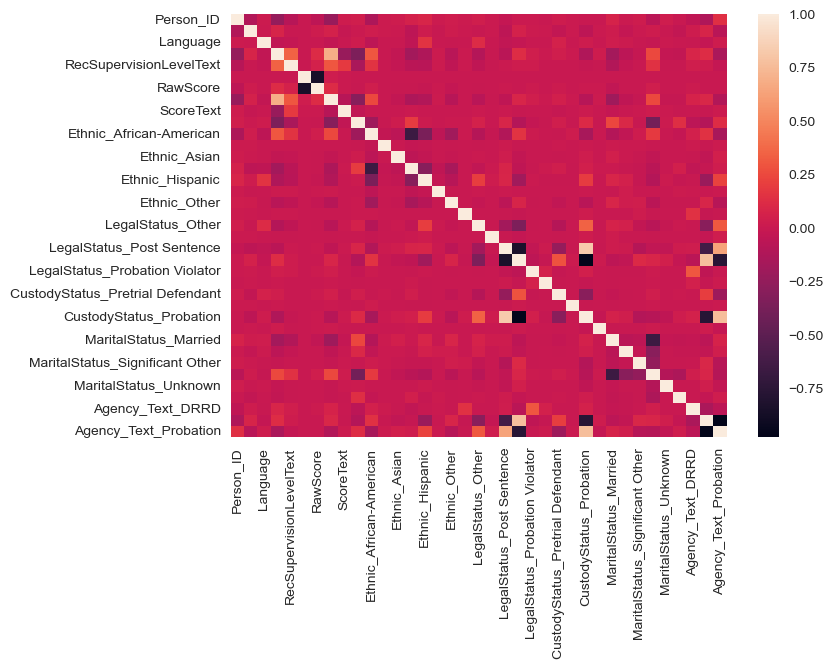

In [23]:
#Matrice de covariance
sns.heatmap(compas_scores_encoded.corr())

nous n'avons pas des fortes corrélations entre les variables

#### partage des données en test et train 

In [24]:
# Define the features X and the target variable y
X = compas_scores_encoded.drop(columns=["DisplayText",'Person_ID', 'RecSupervisionLevelText','DecileScore', 'RawScore', 'ScoreText', 'RecSupervisionLevelText'])
y = compas_scores_encoded['DecileScore']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


### Apprentissage automatique (Classification)

#### AutoML

In [25]:
auto_ml = ClassificationExperiment()
auto_ml.setup(X_train, target=y_train, session_id =1)

,Description,Value
0,Session id,1
1,Target,DecileScore
2,Target type,Multiclass
3,Target mapping,"-1: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10"
4,Original data shape,"(42590, 32)"
5,Transformed data shape,"(42590, 32)"
6,Transformed train set shape,"(29812, 32)"
7,Transformed test set shape,"(12778, 32)"
8,Numeric features,31
9,Preprocess,True


#### Choix du modèle 

In [26]:
# Comparaison de modèles
best = auto_ml.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.3820,0.7647,0.3820,0.3585,0.3316,0.2450,0.2532,1.0290
xgboost,Extreme Gradient Boosting,0.3731,0.7579,0.3731,0.3392,0.3339,0.2334,0.2391,1.0660
lightgbm,Light Gradient Boosting Machine,0.3711,0.7502,0.3711,0.3342,0.3302,0.2317,0.2375,1.1220
ada,Ada Boost Classifier,0.3464,0.6924,0.3464,0.2892,0.2873,0.1930,0.2018,0.9150
lda,Linear Discriminant Analysis,0.3345,0.7338,0.3345,0.2549,0.2587,0.1556,0.1662,0.9690
lr,Logistic Regression,0.3317,0.7368,0.3317,0.2406,0.2411,0.1365,0.1524,1.4250
et,Extra Trees Classifier,0.3277,0.6764,0.3277,0.2909,0.3029,0.1767,0.1785,1.3340
dt,Decision Tree Classifier,0.3274,0.6710,0.3274,0.2902,0.3024,0.1757,0.1775,0.9320
ridge,Ridge Classifier,0.3253,0.0000,0.3253,0.1973,0.2028,0.1102,0.1353,0.9510
knn,K Neighbors Classifier,0.3246,0.6619,0.3246,0.2799,0.2926,0.1622,0.1652,1.0410


#### Le meilleur modeèle est le Gradient Boosting Classifier

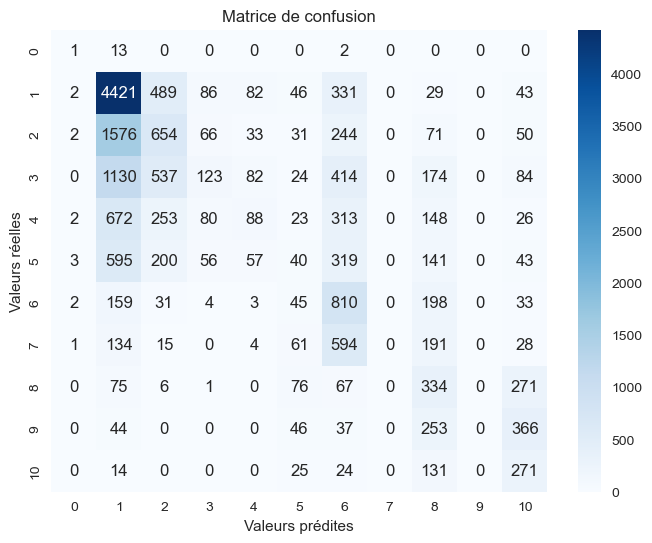

In [27]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

# Faire des prédictions sur l'ensemble de test
y_pred = clf.predict(X_test)

# # Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
# print("Matrice de confusion :")
# print(cm)

# Afficher la matrice de confusion sous forme de figure
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion')
plt.show()

# # Tracer la courbe ROC
# roc_plot = RocCurveDisplay(clf, X_test, y_test)
# plt.show()

#### Courbe de roc

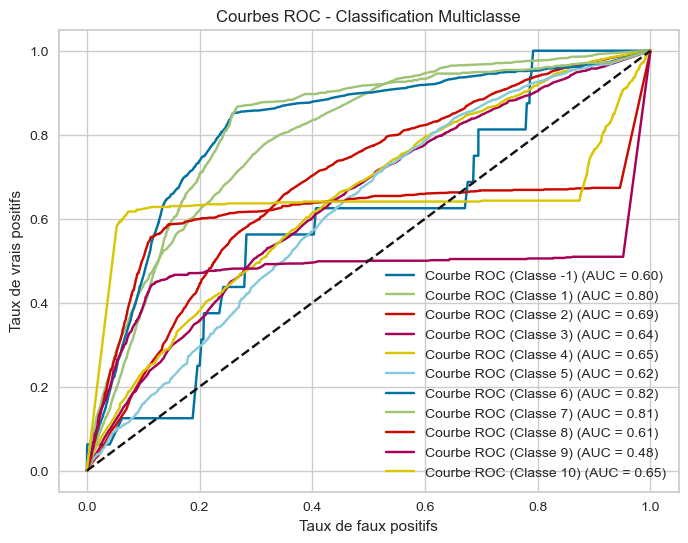

In [28]:
# Obtenir les scores de probabilité prédits pour chaque classe dans l'ensemble de test
y_scores = clf.predict_proba(X_test)

# Calculer les courbes ROC pour chaque classe
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(clf.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_scores[:, i], pos_label=clf.classes_[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Tracer les courbes ROC pour chaque classe
plt.figure(figsize=(8, 6))

for i in range(len(clf.classes_)):
    plt.plot(fpr[i], tpr[i], label='Courbe ROC (Classe {}) (AUC = {:.2f})'.format(clf.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbes ROC - Classification Multiclasse')
plt.legend(loc='lower right')
plt.show()


#### Deuxieme meilleur modèle est le xgboost

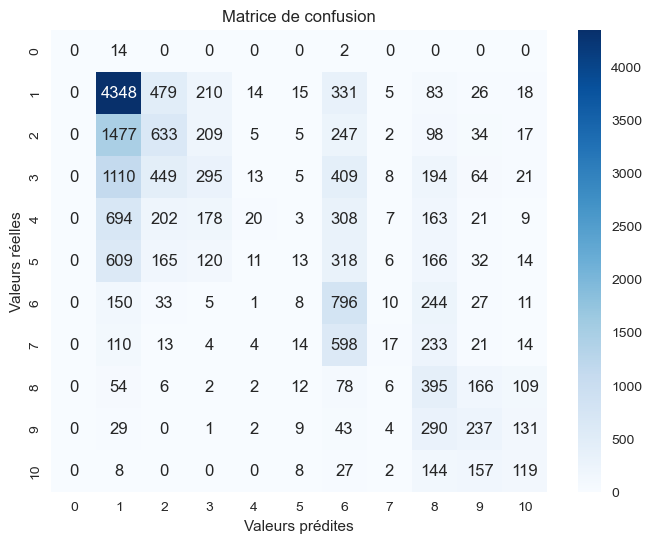

In [29]:
# Convertir les étiquettes en entiers dans la plage attendue
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Créer et entraîner le modèle XGBoost
model = xgboost.XGBClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
model.fit(X_train, y_train_encoded)

# Faire des prédictions sur l'ensemble de test
y_pred_encoded = model.predict(X_test)

# Convertir les prédictions en étiquettes d'origine
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Afficher la matrice de confusion sous forme de figure
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion')
plt.show()


#### Courbe de roc

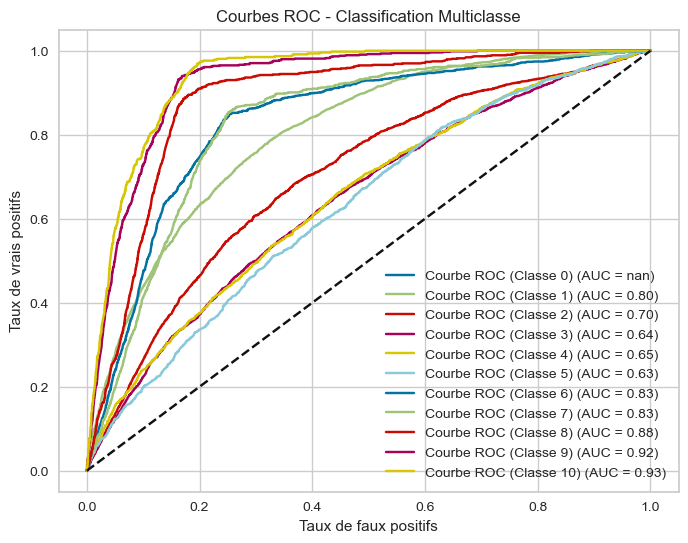

In [30]:
# Obtenir les scores de probabilité prédits pour chaque classe dans l'ensemble de test
y_scores = model.predict_proba(X_test)

# Calculer les courbes ROC pour chaque classe
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(clf.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_scores[:, i], pos_label=model.classes_[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Tracer les courbes ROC pour chaque classe
plt.figure(figsize=(8, 6))

for i in range(len(model.classes_)):
    plt.plot(fpr[i], tpr[i], label='Courbe ROC (Classe {}) (AUC = {:.2f})'.format(model.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbes ROC - Classification Multiclasse')
plt.legend(loc='lower right')
plt.show()

#### Analyse de l'influence des features sur le modèle.

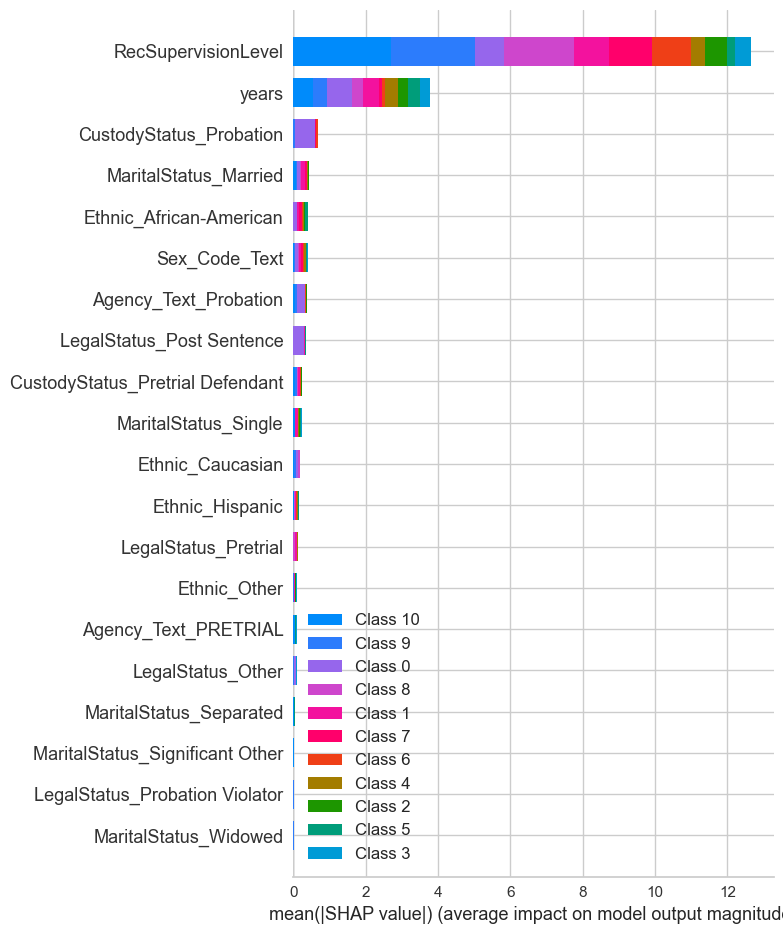

In [31]:
explainer_compas_score = shap.Explainer(model)
shap_values_compas = explainer_compas_score.shap_values(X_test)

feature_contributions = shap.summary_plot(shap_values_compas, X_test, plot_type="bar")

Nous observons que la variables RecRevisionLevel et l'age sont les plus influent de notre modèle.   

In [32]:
def shap_force_plot(explainer, values, X):
    """
    shap_value can be an element of explainer.shap_values(train_X) or subset
    """
    shap.initjs()
    display(shap.force_plot(explainer.expected_value[0], values[0], X))
    return

index=1
tree_explainer = shap.TreeExplainer(model)
tree_values = tree_explainer.shap_values(X_train)

tree_values_array = np.array(tree_values)

shap_force_plot(tree_explainer, tree_values_array[index, :], X_train.iloc[index, :])


In [33]:
index = 5
tree_explainer = shap.TreeExplainer(model)
tree_values = tree_explainer.shap_values(X_train)

tree_values_array = np.array(tree_values)

shap_force_plot(tree_explainer, tree_values_array[index, :], X_train.iloc[index, :])


### Amélioration de l’équité du modèle.

Nous avons choisi de rééchantillonner les données en suivant la véritable répartition étnique de la population.

In [34]:
# Charger les données compasScoreRaw dans un DataFrame
df = pd.read_csv("./archive/compas-scores-raw.csv")

# Créer des DataFrames séparés pour chaque groupe ethnique
df_black = df[df['Ethnic_Code_Text'] == 'African-American']
df_white = df[df['Ethnic_Code_Text'] == 'Caucasian']
df_hispanic = df[df['Ethnic_Code_Text'] == 'Hispanic']
df_other = df[df['Ethnic_Code_Text'] == 'Other']
df_asian = df[df['Ethnic_Code_Text'] == 'Asian']
df_native = df[df['Ethnic_Code_Text'] == 'Native American']

# Rééchantillonner chaque groupe ethnique pour obtenir la proportion souhaitée
df_black_resampled = resample(df_black, replace=True, n_samples=int(0.22 * len(df)), random_state=42)
df_white_resampled = resample(df_white, replace=True, n_samples=int(0.52 * len(df)), random_state=42)
df_hispanic_resampled = resample(df_hispanic, replace=True, n_samples=int(0.171 * len(df)), random_state=42)
df_other_resampled = resample(df_other, replace=True, n_samples=int(0.024 * len(df)), random_state=42)
df_asian_resampled = resample(df_asian, replace=True, n_samples=int(0.0507 * len(df)), random_state=42)
df_native_resampled = resample(df_native, replace=True, n_samples=int(0.0082 * len(df)), random_state=42)

# Concaténer les DataFrames rééchantillonnés pour former le nouveau jeu de données équilibré
df_resampled = pd.concat([df_black_resampled, df_white_resampled, df_hispanic_resampled, df_other_resampled, df_asian_resampled, df_native_resampled])

# Afficher le nouveau jeu de données équilibré dans Streamlit
df_resampled.head()


,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,...,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
52868,66236,76689,69424,Probation,Lilly,Alvin,NaN,Male,African-American,05/21/89,...,1,Low,18,Risk of Failure to Appear,15.00,1,Low,New,1,0
34932,58348,70035,60574,PRETRIAL,GUILLAUME,JOHN,JONERCE,Male,African-American,05/20/94,...,2,Medium,7,Risk of Violence,-1.67,6,Medium,New,1,0
1703,12222,57742,52462,PRETRIAL,TERRY,WILLIE,JAMES,Male,African-American,03/22/81,...,2,Medium,18,Risk of Failure to Appear,15.00,1,Low,New,1,0
11228,54068,61255,55612,PRETRIAL,Williams,Finest,NaN,Male,African-American,03/27/95,...,4,High,18,Risk of Failure to Appear,15.00,1,Low,New,1,0
48365,56897,65017,58989,PRETRIAL,Polynice,Gregory,NaN,Male,African-American,01/06/78,...,2,Medium,18,Risk of Failure to Appear,34.00,10,High,New,1,0


In [35]:
# Définition de la fonction qui calcule l'âge en années
def dateOfBirthTransform(P,G):
    
    formatting = "%m/%d/%Y"
    x = P.split("/")
    if x[-2] == "0":
        x[-1] = "20" + x[-1][-2:]
    else:
        x[-1] = "19" + x[-1][-2:] # remplace les deux derniers caractères par "19" + les deux derniers caractères
    date_string = "/".join(x)
#     print(x)
    date2 = datetime.strptime(G, '%m/%d/%y %H:%M')
    date_object = datetime.strptime(date_string, formatting)

    
    age = (date2 - date_object).days // 365
#     print("Age:", age)
    return int(age)
# Application de la fonction à chaque ligne du dataframe
#compas_scores_raw["Age"] = compas_scores_raw.apply(dateOfBirthTransform, axis=1)
df_resampled['years']=df_resampled.apply(lambda row: dateOfBirthTransform(row["DateOfBirth"], row["Screening_Date"]), axis=1)

#### diagramme circulaire nouvelle répartition de la population.

In [36]:
df_resampled.shape

(60469, 29)

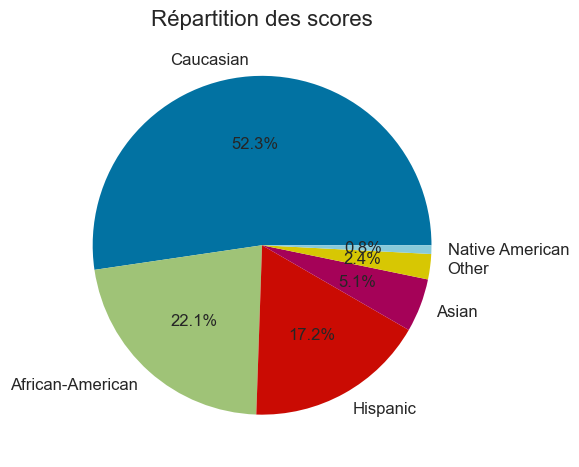

In [37]:
ethnic_counts = df_resampled['Ethnic_Code_Text'].value_counts()

plt.pie(ethnic_counts, labels=ethnic_counts.index, autopct=lambda pct: "{:.1f}%".format(pct), textprops={'fontsize': 12})

plt.title("Répartition des scores", fontsize=16)

plt.show()

In [38]:
#Suppression de certainnes colonnes 
df_resampled = df_resampled.drop(['AssessmentID', 'Case_ID',  'LastName',
       'FirstName', 'MiddleName', 'DateOfBirth', 'ScaleSet_ID', 'ScaleSet', 'AssessmentReason',
       'Screening_Date', 'Scale_ID',  'AssessmentType', 'IsCompleted', 'IsDeleted', ], axis=1)

In [39]:
# Appliquer le one-hot encoding à la variable "Ethnic_Code_Text"
one_hot_encoded_ethnic = pd.get_dummies(df_resampled['Ethnic_Code_Text'], prefix='Ethnic')

# Fusionner les données encodées avec le dataframe d'origine
df_resampled_encoded = pd.concat([df_resampled, one_hot_encoded_ethnic], axis=1)

# Afficher les données encodées
df_resampled_encoded.head()

,Person_ID,Agency_Text,Sex_Code_Text,Ethnic_Code_Text,Language,LegalStatus,CustodyStatus,MaritalStatus,RecSupervisionLevel,RecSupervisionLevelText,...,RawScore,DecileScore,ScoreText,years,Ethnic_African-American,Ethnic_Asian,Ethnic_Caucasian,Ethnic_Hispanic,Ethnic_Native American,Ethnic_Other
52868,66236,Probation,Male,African-American,English,Post Sentence,Probation,Single,1,Low,...,15.00,1,Low,25,1,0,0,0,0,0
34932,58348,PRETRIAL,Male,African-American,English,Pretrial,Pretrial Defendant,Single,2,Medium,...,-1.67,6,Medium,19,1,0,0,0,0,0
1703,12222,PRETRIAL,Male,African-American,English,Pretrial,Jail Inmate,Single,2,Medium,...,15.00,1,Low,31,1,0,0,0,0,0
11228,54068,PRETRIAL,Male,African-American,English,Pretrial,Jail Inmate,Single,4,High,...,15.00,1,Low,18,1,0,0,0,0,0
48365,56897,PRETRIAL,Male,African-American,English,Pretrial,Pretrial Defendant,Single,2,Medium,...,34.00,10,High,36,1,0,0,0,0,0


In [40]:
# Variables nécessitant le label encoding
label_encoding_cols = ['Sex_Code_Text', 'DisplayText', 'Language', 'ScoreText', 'RecSupervisionLevelText']

# Variables nécessitant le one-hot encoding
one_hot_encoding_cols = ['LegalStatus','CustodyStatus','MaritalStatus', 'Agency_Text']

# Appliquer le label encoding
label_encoder = LabelEncoder()
for col in label_encoding_cols:
    df_resampled_encoded[col] = label_encoder.fit_transform(df_resampled[col])

# Appliquer le one-hot encoding
one_hot_encoded_data = pd.get_dummies(df_resampled_encoded[one_hot_encoding_cols], drop_first=True)

# Fusionner les données encodées
df_resampled_encoded = pd.concat([df_resampled_encoded.drop(one_hot_encoding_cols, axis=1), one_hot_encoded_data], axis=1)

df_resampled_encoded = df_resampled_encoded.drop(columns=['Ethnic_Code_Text'])
# Afficher les données encodées
df_resampled_encoded.head()

,Person_ID,Sex_Code_Text,Language,RecSupervisionLevel,RecSupervisionLevelText,DisplayText,RawScore,DecileScore,ScoreText,years,...,CustodyStatus_Residential Program,MaritalStatus_Married,MaritalStatus_Separated,MaritalStatus_Significant Other,MaritalStatus_Single,MaritalStatus_Unknown,MaritalStatus_Widowed,Agency_Text_DRRD,Agency_Text_PRETRIAL,Agency_Text_Probation
52868,66236,1,0,1,1,0,15.00,1,1,25,...,0,0,0,0,1,0,0,0,0,1
34932,58348,1,0,2,2,2,-1.67,6,2,19,...,0,0,0,0,1,0,0,0,1,0
1703,12222,1,0,2,2,0,15.00,1,1,31,...,0,0,0,0,1,0,0,0,1,0
11228,54068,1,0,4,0,0,15.00,1,1,18,...,0,0,0,0,1,0,0,0,1,0
48365,56897,1,0,2,2,0,34.00,10,0,36,...,0,0,0,0,1,0,0,0,1,0


In [41]:
# Define the features X and the target variable y
X = df_resampled_encoded.drop(columns=["DisplayText",'Person_ID', 'RecSupervisionLevelText','DecileScore', 'RawScore', 'ScoreText', 'RecSupervisionLevelText'])
y = df_resampled_encoded['DecileScore']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


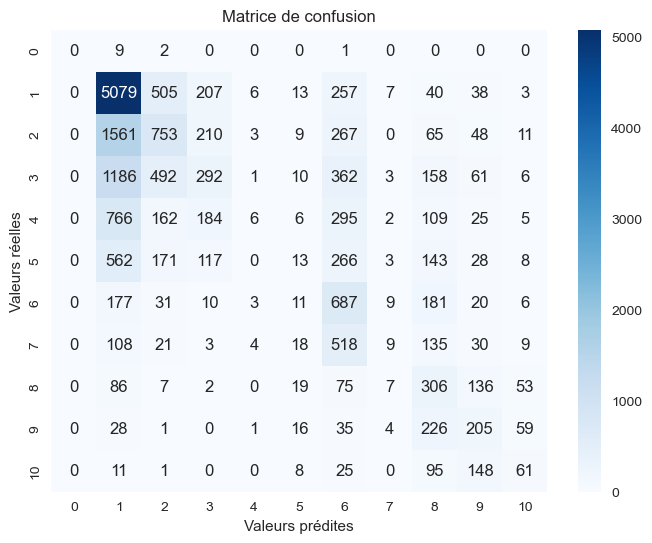

In [42]:
# Convertir les étiquettes en entiers dans la plage attendue
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Créer et entraîner le modèle XGBoost
model = xgboost.XGBClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
model.fit(X_train, y_train_encoded)

# Faire des prédictions sur l'ensemble de test
y_pred_encoded = model.predict(X_test)

# Convertir les prédictions en étiquettes d'origine
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Afficher la matrice de confusion sous forme de figure
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion')
plt.show()

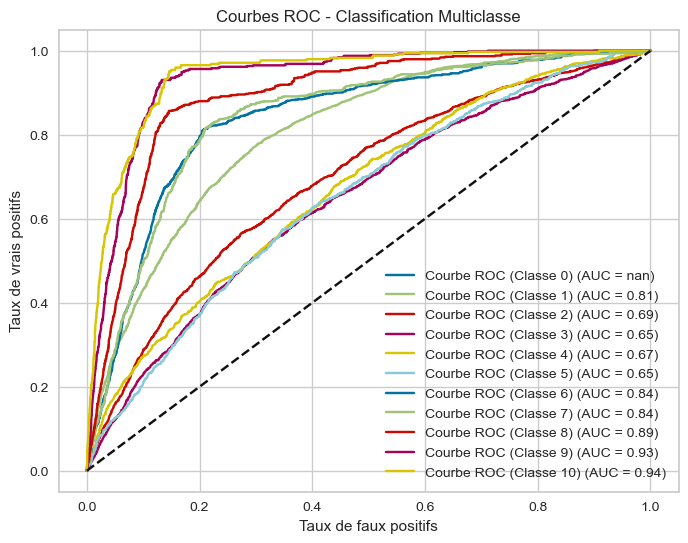

In [43]:
# Obtenir les scores de probabilité prédits pour chaque classe dans l'ensemble de test
y_scores = model.predict_proba(X_test)

# Calculer les courbes ROC pour chaque classe
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(clf.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_scores[:, i], pos_label=model.classes_[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Tracer les courbes ROC pour chaque classe
plt.figure(figsize=(8, 6))

for i in range(len(model.classes_)):
    plt.plot(fpr[i], tpr[i], label='Courbe ROC (Classe {}) (AUC = {:.2f})'.format(model.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbes ROC - Classification Multiclasse')
plt.legend(loc='lower right')
plt.show()

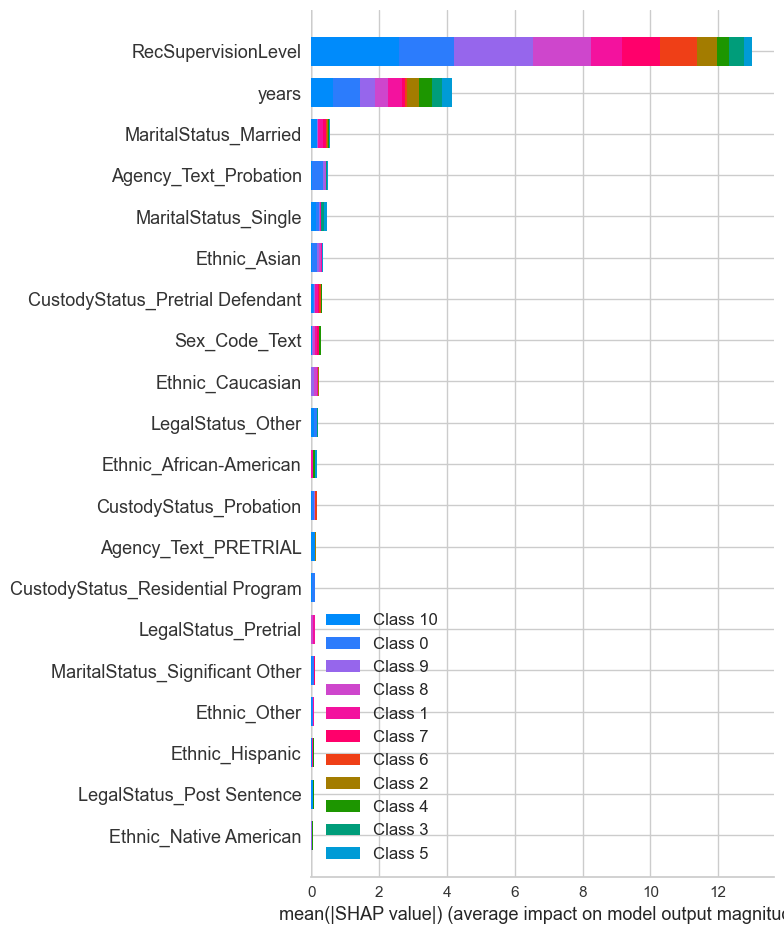

In [44]:
explainer_compas_score = shap.Explainer(model)
shap_values_compas = explainer_compas_score.shap_values(X_test)

feature_contributions = shap.summary_plot(shap_values_compas, X_test, plot_type="bar")

Nous remarquons une atténuation de la sensibilité de l'éthnie Afro-Américaine, mais nous remarquons également une augmentation de la sensibilité de l'ethnie Caucasienne.

In [45]:
def shap_force_plot(explainer, values, X):
    """
    shap_value can be an element of explainer.shap_values(train_X) or subset
    """
    shap.initjs()
    display(shap.force_plot(explainer.expected_value[0], values[0], X))
    return

index=1
tree_explainer = shap.TreeExplainer(model)
tree_values = tree_explainer.shap_values(X_train)

tree_values_array = np.array(tree_values)

shap_force_plot(tree_explainer, tree_values_array[index, :], X_train.iloc[index, :])